In [10]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from pyhht import EMD
from scipy.stats import norm
from scipy.stats import entropy
from tqdm import tqdm
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [7]:
import numpy as np
import pickle
from scipy.signal import butter, lfilter

nLabel, nTrial, nUser, nChannel, nTime = 4, 40, 32, 32, 8064
lowcut = 2  # Hz
highcut = 45  # Hz
fs = 128  # Hz
order = 5  # Butterworth filter order
window_size = 512
stride = 256

no_of_users = 32
users_windows = []  # List to store windows for each user

# LOOP FOR USERS
for i in range(no_of_users):
    windows = []  # List to store windows for the current user

    if i < 9:
        name = f'0{i + 1}'
    else:
        name = str(i + 1)

    fname = f"D://Charan_Project//THESIS//project//data_preprocessed//s{name}.dat"
    x = pickle.load(open(fname, 'rb'), encoding='latin1')
    data = x['data']
    labels = x['labels']

    new_trail = np.zeros((nTrial, nChannel, nTime - 384))

    # LOOP FOR 40 TRIALS
    for k in range(nTrial):
        trial = data[k]
        EEG_Trial = trial[0:32, :]
        Ctrial = EEG_Trial - np.mean(EEG_Trial, axis=0)
        new_trail[k] = Ctrial[0:32, 384:8064]

        # Loop for 32 channels
        for K in range(nChannel):
            # Filtering
            def butter_bandpass(lowcut, highcut, fs, order): 
                nyq = 0.5 * fs
                low = lowcut / nyq
                high = highcut / nyq
                b, a = butter(order, [low, high], btype='band')
                return b, a

            def butter_bandpass_filter(data, lowcut, highcut, fs, order):
                b, a = butter_bandpass(lowcut, highcut, fs, order=order)
                y = lfilter(b, a, data)
                return y

            # Apply bandpass filter for new trial
            new_trail[k, K] = butter_bandpass_filter(new_trail[k, K], lowcut, highcut, fs, order)

            # Create sliding windows of 4 seconds with stride of 2 seconds for each channel
            for j in range(29):
                windows.append(new_trail[k][K][j * stride: j * stride + window_size])

    users_windows.append(windows)  # Store windows for the current user

# Now users_windows contains lists of windows for each user
# Access windows for a specific user (e.g., user 1)
user_1_windows = users_windows[0]
print("Number of windows for user 1:", len(user_1_windows))


Number of windows for user 1: 37120


In [8]:
np.array(users_windows).shape

(32, 37120, 512)

In [12]:
import numpy as np
from pyhht import EMD
from scipy.stats import entropy

# Assuming user_windows[0] contains the windows for the first user
user_windows = users_windows[0]


# List to store DDE features for each window
dde_features = []

# Loop through each window
for window in user_windows:
    # Apply EMD to the window
    decomposer = EMD(window,n_imfs=4)  # Provide input data during initialization
    imfs = decomposer.decompose()    # Perform Empirical Mode Decomposition)
    
    # Calculate differential entropy for each IMF
    imf_dde = []
    for imf in imfs:
        p_density = np.histogram(imf, density=True)[0]
        dde = -np.sum(p_density * np.log2(p_density + 1e-10))
        imf_dde.append(dde)
    
    # Append the DDE values for this window to the features list
    dde_features.append(imf_dde)

# Convert the DDE features list to a numpy array
dde_features_array = np.array(dde_features)
print("Shape of DDE features array:", dde_features_array.shape) #(37120,5)


Mode 3, Iteration 600
1 minima > 0; 22 maxima < 0.
Mode 3, Iteration 800
1 minima > 0; 22 maxima < 0.
Mode 2, Iteration 600
0 minima > 0; 44 maxima < 0.
Shape of DDE features array: (37120, 5)


In [11]:
dde_features_array

array([[ 1.67919583,  1.68140597,  3.32896003,  3.20929609, -1.10452853],
       [ 1.89802877,  2.26396987,  1.78895616,  3.55071744, -2.07067137],
       [ 2.39082458,  1.842406  ,  2.1210089 ,  3.49276451,  3.88498085],
       ...,
       [ 2.23699293,  2.51641074,  2.65907774,  5.10676664, -0.90750345],
       [ 1.45540708,  2.22174815,  3.31102711,  3.19906077,  3.74648238],
       [ 1.1009811 ,  1.28211542,  3.17423611,  3.5189451 ,  3.41804617]])

In [13]:
# List to store participant DDE features arrays
subject_dde_features = []

# Counter for windows with IMF features less than 5
windows_with_less_than_5_imfs = 0

for user_windows in users_windows:
    # List to store DDE features for each window
    dde_features = []

    for window in user_windows:
        #Apply EMD to the window
        decomposer = EMD(window,n_imfs=4) #Provide input data and number of IMFs to decompose
        imfs = decomposer.decompose() #Decompose the signal into IMFs

        # Calculate differential entropy for each IMF
        imf_dde = []
        for imf in imfs:
            p_density = np.histogram(imf, density=True)[0]
            dde = -np.sum(p_density * np.log2(p_density + 1e-10))
            imf_dde.append(dde)
        
        # Pad or truncate IMF features to make them consistent
        while len(imf_dde) < 5:
            imf_dde.append(0.0)  # Pad with zeros
        
        # Append the DDE values for this window to the features list
        dde_features.append(imf_dde)
        
        if len(imf_dde) < 5:
            windows_with_less_than_5_imfs += 1
    
    # Convert the DDE features list to a numpy array
    dde_features_array = np.array(dde_features)

    # Reshape the array to (40,1,29,160)
    dde_features_array_reshaped = dde_features_array.reshape(40,1,29,160)

    #Append the DDE features array for this participant to the list
    subject_dde_features.append(dde_features_array_reshaped)

# Save the reshaped arrays for each participant
for i,dde_features_array in enumerate(subject_dde_features):
    participant_id = i+1
    np.save(f'subj_{participant_id}_dde_features.npy', dde_features_array)



print(f"Number of windows with IMF features less than 5: {windows_with_less_than_5_imfs}")


Mode 3, Iteration 600
1 minima > 0; 22 maxima < 0.
Mode 3, Iteration 800
1 minima > 0; 22 maxima < 0.
Mode 2, Iteration 600
0 minima > 0; 44 maxima < 0.
Mode 3, Iteration 600
1 minima > 0; 20 maxima < 0.
Mode 3, Iteration 800
1 minima > 0; 20 maxima < 0.
Mode 3, Iteration 1000
1 minima > 0; 20 maxima < 0.
Mode 3, Iteration 1200
1 minima > 0; 20 maxima < 0.
Mode 3, Iteration 1400
1 minima > 0; 20 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 11 maxima < 0.
Mode 4, Iteration 800
1 minima > 0; 11 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 13 maxima < 0.
Mode 4, Iteration 800
1 minima > 0; 13 maxima < 0.
Mode 4, Iteration 1000
1 minima > 0; 13 maxima < 0.
Mode 4, Iteration 1200
1 minima > 0; 13 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 4, Iteration 800
0 minima > 0; 12 maxima < 0.
Mode 3, Iteration 600
0 minima > 0; 21 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 12 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 8 maxima < 0.
Mode 3, Iteration 600
0 min

c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyhht\emd.py:367: UserWarning: Emd:warning, Forced stop of sifting - Maximum iteration limit reached.
  warnings.warn("Emd:warning, Forced stop of sifting - " +


Mode 4, Iteration 600
0 minima > 0; 9 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 12 maxima < 0.
Mode 3, Iteration 600
1 minima > 0; 15 maxima < 0.
Mode 3, Iteration 800
1 minima > 0; 15 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 14 maxima < 0.
Mode 4, Iteration 800
0 minima > 0; 14 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 4, Iteration 600
0 minima > 0; 11 maxima < 0.
Mode 4, Iteration 800
0 minima > 0; 11 maxima < 0.
Mode 3, Iteration 600
0 minima > 0; 26 maxima < 0.
Mode 3, Iteration 800
1 minima > 0; 26 maxima < 0.
Mode 3, Iteration 1000
1 minima > 0; 26 maxima < 0.
Mode 3, Iteration 1200
0 minima > 0; 27 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 15 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 10 maxima < 0.
Mode 4, Iteration 800
1 minima > 0; 10 maxima < 0.
Mode 4, Iteration 1000
1 minima > 0; 10 maxima < 0.
Mode 4, Iteration 600
1 minima > 0; 16 maxima < 0.
Mode 4, Iteration 800
1 minim

In [21]:
import numpy as np

# Load the saved DDE features array for subj_1
dde_features_array_subj_1 = np.load('subj_1_dde_features.npy')
dde_features_array_subj_32 = np.load('subj_32_dde_features.npy')

# Print the shape of the loaded array
print("Shape of dde_features_array_subj_1:", dde_features_array_subj_1.shape)
print("Shape of dde_features_array_subj_2:", dde_features_array_subj_32.shape)

print(dde_features_array_subj_1)
print(dde_features_array_subj_32)


Shape of dde_features_array_subj_1: (40, 1, 29, 160)
Shape of dde_features_array_subj_2: (40, 1, 29, 160)
[[[[ 1.67919583  1.68140597  3.32896003 ...  1.9401077   4.87033487
     2.28804755]
   [ 1.91040588  1.32346806  2.27297452 ...  2.50931346  3.46548417
     2.20866494]
   [ 1.8068902   1.78606085  2.72211455 ...  2.32576646  3.92492115
     4.02337225]
   ...
   [ 1.85719002  2.45164892  2.17157783 ...  3.44416547  4.31098004
     2.86336504]
   [ 2.69034011  2.53593064  2.97799501 ...  2.7118295   4.34828156
     3.37477145]
   [ 1.7943909   2.02277714  3.23239374 ...  3.55030052  1.99696852
     0.00959685]]]


 [[[ 1.24773413  2.18310987  2.65003488 ...  2.82654198  2.71323091
    -3.1452804 ]
   [ 1.56652771  2.24477437  2.97175505 ...  2.39444868  2.93438722
     4.45959288]
   [ 1.99832268  1.35539588  2.62905852 ...  0.97947288  1.56407742
     3.61732194]
   ...
   [ 1.94875448  1.61138075  2.20428309 ...  3.22473976  2.90805739
     3.38173305]
   [ 1.26024741  2.5577107

**LABELS**

In [11]:

def read_data(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    data = x.load()
    return data

files = []
for n in range(1, 33): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
# print(files)

labels = []
data = []
for i in files: 
    fileph = "D://Charan_Project//THESIS//project//data_preprocessed//s" + i + ".dat"
    d = read_data(fileph)
    labels.append(d['labels'])
    data.append(d['data'])  #32,40,40,8064

In [12]:
labels=np.array(labels)
np.array(labels).shape

(32, 40, 4)

In [13]:
valence = labels[:, :, 0]  #32,40
arousal = labels[:, :, 1]   #32,40

In [14]:
print(np.median(valence))
print(np.median(arousal))

5.04
5.23


In [15]:
import numpy as np

# Assuming you have the valence and arousal arrays with shape (32, 40)

def convert_to_quadrant(valence, arousal):
    valence_median = np.median(valence)
    arousal_median = np.median(arousal)
    
    quadrant_labels = []
    for v, a in zip(valence.ravel(), arousal.ravel()):
        if v <= valence_median and a <= arousal_median:
            quadrant_labels.append('LALV')
        elif v <= valence_median and a > arousal_median:
            quadrant_labels.append('LAHV')
        elif v > valence_median and a <= arousal_median:
            quadrant_labels.append('HALV')
        else:
            quadrant_labels.append('HAHV')
    return np.array(quadrant_labels).reshape(valence.shape)

# Convert valence and arousal to quadrant labels
quadrant_labels = convert_to_quadrant(valence, arousal)

# Print the resulting quadrant labels array
print("Quadrant labels array:\n", quadrant_labels) # (32, 40)


Quadrant labels array:
 [['HAHV' 'HAHV' 'HAHV' ... 'LAHV' 'LAHV' 'HAHV']
 ['HALV' 'HAHV' 'HAHV' ... 'LAHV' 'LALV' 'HAHV']
 ['HALV' 'HALV' 'HALV' ... 'LAHV' 'LAHV' 'HALV']
 ...
 ['LALV' 'HAHV' 'HAHV' ... 'LALV' 'LALV' 'HALV']
 ['HAHV' 'LAHV' 'HALV' ... 'LAHV' 'LAHV' 'LAHV']
 ['HALV' 'LALV' 'HAHV' ... 'LAHV' 'LAHV' 'HALV']]


In [16]:
import numpy as np

# Assuming you have the quadrant_labels array with shape (32, 40)

# Calculate unique labels and their counts
unique_labels, label_counts = np.unique(quadrant_labels, return_counts=True)

# Print the unique labels and their counts
for label, count in zip(unique_labels, label_counts):
    print(f"{label}: {count} occurrences")


HAHV: 354 occurrences
HALV: 284 occurrences
LAHV: 286 occurrences
LALV: 356 occurrences


In [17]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models


In [18]:
# Load participant DDE features
participant_dde_features = []  # List to store participant DDE features arrays
for i in range(1, 33):
    dde_features_array = np.load(f'subj_{i}_dde_features.npy')
    participant_dde_features.append(dde_features_array)
participant_dde_features = np.array(participant_dde_features)

# Load quadrant labels
quadrant_labels = np.array(quadrant_labels)


In [19]:
participant_dde_features= participant_dde_features.reshape(32, 40, 29, 160)
participant_dde_features.shape


(32, 40, 29, 160)

**MODEL**

In [20]:
def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  # 4 classes for quadrants
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [22]:
# Create a mapping from quadrant labels to integers
label_mapping = {'LALV': 0, 'LAHV': 1, 'HALV': 2, 'HAHV': 3}

# Convert quadrant labels to integers using the mapping
quadrant_labels_int = np.array([[label_mapping[label] for label in subject] for subject in quadrant_labels])

In [23]:
quadrant_labels_int

array([[3, 3, 3, ..., 1, 1, 3],
       [2, 3, 3, ..., 1, 0, 3],
       [2, 2, 2, ..., 1, 1, 2],
       ...,
       [0, 3, 3, ..., 0, 0, 2],
       [3, 1, 2, ..., 1, 1, 1],
       [2, 0, 3, ..., 1, 1, 2]])

In [24]:
subject_ids = np.repeat(np.arange(32), 40)

subject_ids.shape


(1280,)

In [33]:
print(participant_dde_features.shape)
print(quadrant_labels_int.shape)
print(subject_ids.shape)

(32, 40, 29, 160)
(32, 40)
(1280,)


In [26]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from keras import layers, models

# Create a mapping from quadrant labels to integers
label_mapping = {'LALV': 0, 'LAHV': 1, 'HALV': 2, 'HAHV': 3}

# Convert quadrant labels to integers using the mapping
quadrant_labels_int = np.array([[label_mapping[label] for label in subject] for subject in quadrant_labels])

# Define the CNN model
def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))  # 4 classes for quadrants
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
    return model


In [46]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


num_subjects = participant_dde_features.shape[0]
num_trials = participant_dde_features.shape[1]
num_classes = 4  # Assuming you have 4 emotion classes

# Reshape the data to fit the CNN input shape
input_shape = (participant_dde_features.shape[2], participant_dde_features.shape[3], 1)

# Initialize KFold cross-validation
kf = KFold(n_splits=num_subjects)

# Placeholder for storing accuracy scores
accuracy_scores = []

# Iterate through each subject as the test set
for train_subjects, test_subjects in kf.split(np.arange(num_subjects)):
    # Select data for training and testing
    X_train = participant_dde_features[train_subjects].reshape(-1, *input_shape)
    y_train = quadrant_labels_int[train_subjects].flatten()
    
    X_test = participant_dde_features[test_subjects].reshape(-1, *input_shape)
    y_test = quadrant_labels_int[test_subjects].flatten()
    
    # Create the CNN model
    model = create_cnn_model(input_shape)
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred_classes)
    accuracy_scores.append(accuracy)

# Calculate the average accuracy
average_accuracy = np.mean(accuracy_scores)
print("Average Classification Accuracy:", average_accuracy)


2/2 [==============================] - 0s 16ms/step
Average Classification Accuracy: 0.259375


In [47]:
# After training the model
model.save("emotion_recognition_model.h5")


c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
kf = KFold(n_splits=32)
input_shape = (participant_dde_features.shape[2], participant_dde_features.shape[3], 1)


In [29]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import KFold
import scikeras
from scikeras.wrappers import KerasClassifier

# Define a wrapper class for KerasClassifier that includes dropout_rate
class MyKerasClassifier(KerasClassifier):
    def __init__(self, dropout_rate=0.2, **kwargs):
        self.dropout_rate = dropout_rate
        super().__init__(**kwargs)

    def build_fn(self):
        return create_cnn_model(dropout_rate=self.dropout_rate)

# Define a function to create your CNN model
def create_cnn_model(optimizer='adam', dropout_rate=0.2):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))  # 4 classes for quadrants
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the parameter grid to search through
param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Create a KerasClassifier wrapper for scikit-learn
model = MyKerasClassifier(build_fn=create_cnn_model, epochs=10, batch_size=32, verbose=0)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(accuracy_score), cv=kf)

# Fit the grid search to the data
grid_result = grid.fit(participant_dde_features.reshape(-1, *input_shape), quadrant_labels_int.flatten())

# Print the best combination of hyperparameters and the corresponding accuracy
print("Best Hyperparameters:", grid_result.best_params_)
print("Best Accuracy:", grid_result.best_score_)


c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which

c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\Charan\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which

Best Hyperparameters: {'dropout_rate': 0.3, 'optimizer': 'adam'}
Best Accuracy: 0.27890625


In [48]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [76]:
# Define a function to create your CNN model with various strategies
def create_cnn_model(input_shape, dropout_rate=0.3, regularization_strength=0.01):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_strength)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

Epoch 1/1000
31/31 [==============================] - 8s 255ms/step - loss: 3.3084 - accuracy: 0.2530 - val_loss: 2.9848 - val_accuracy: 0.3065 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 252ms/step - loss: 2.8880 - accuracy: 0.3075 - val_loss: 2.7830 - val_accuracy: 0.3105 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 253ms/step - loss: 2.6773 - accuracy: 0.3448 - val_loss: 2.6368 - val_accuracy: 0.3185 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 249ms/step - loss: 2.4937 - accuracy: 0.4083 - val_loss: 2.5869 - val_accuracy: 0.1976 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 249ms/step - loss: 2.3283 - accuracy: 0.4708 - val_loss: 2.5101 - val_accuracy: 0.2339 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 251ms/step - loss: 2.2211 - accuracy: 0.4899 - val_loss: 2.4669 - val_accuracy: 0.3024 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

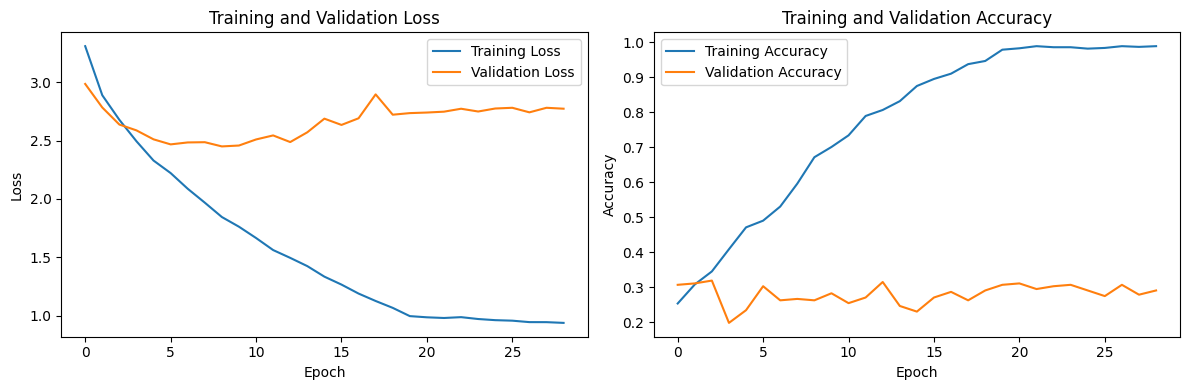

Epoch 1/1000
31/31 [==============================] - 8s 250ms/step - loss: 3.5637 - accuracy: 0.2732 - val_loss: 3.0612 - val_accuracy: 0.2177 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 7s 241ms/step - loss: 2.8890 - accuracy: 0.3004 - val_loss: 2.7603 - val_accuracy: 0.3105 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 7s 239ms/step - loss: 2.6594 - accuracy: 0.3458 - val_loss: 2.6649 - val_accuracy: 0.2177 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 243ms/step - loss: 2.4755 - accuracy: 0.3931 - val_loss: 2.5207 - val_accuracy: 0.3105 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 244ms/step - loss: 2.3141 - accuracy: 0.4808 - val_loss: 2.4913 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 251ms/step - loss: 2.1967 - accuracy: 0.5161 - val_loss: 2.4126 - val_accuracy: 0.2984 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

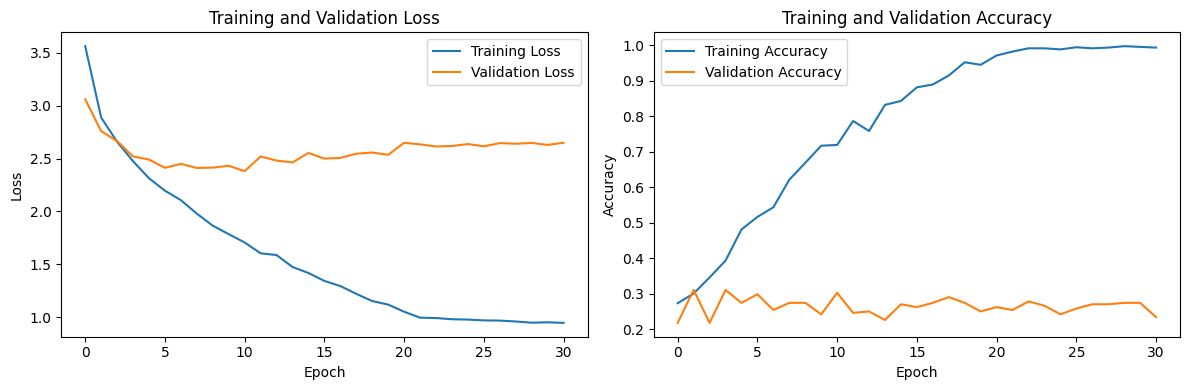

Epoch 1/1000
31/31 [==============================] - 9s 276ms/step - loss: 3.3361 - accuracy: 0.2440 - val_loss: 3.1107 - val_accuracy: 0.3185 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 273ms/step - loss: 2.9225 - accuracy: 0.3145 - val_loss: 2.8427 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 273ms/step - loss: 2.6764 - accuracy: 0.3760 - val_loss: 2.6966 - val_accuracy: 0.2903 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 267ms/step - loss: 2.4928 - accuracy: 0.4526 - val_loss: 2.7015 - val_accuracy: 0.2661 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 270ms/step - loss: 2.3220 - accuracy: 0.5071 - val_loss: 2.5553 - val_accuracy: 0.2903 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 267ms/step - loss: 2.1875 - accuracy: 0.5544 - val_loss: 2.4952 - val_accuracy: 0.3347 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

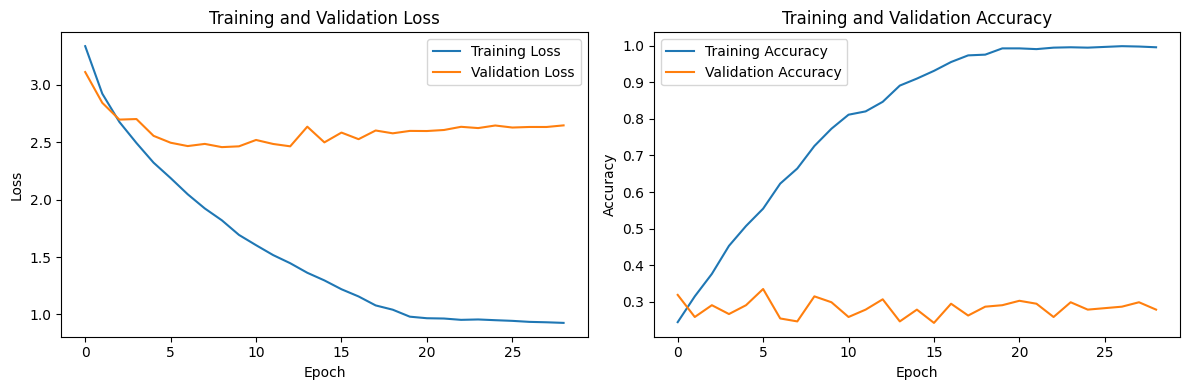

Epoch 1/1000
31/31 [==============================] - 9s 268ms/step - loss: 3.4200 - accuracy: 0.2329 - val_loss: 2.9597 - val_accuracy: 0.2984 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 268ms/step - loss: 2.8535 - accuracy: 0.2994 - val_loss: 2.8018 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 262ms/step - loss: 2.6156 - accuracy: 0.3256 - val_loss: 2.6518 - val_accuracy: 0.2137 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 262ms/step - loss: 2.3897 - accuracy: 0.3921 - val_loss: 2.4470 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 265ms/step - loss: 2.2460 - accuracy: 0.4577 - val_loss: 2.4527 - val_accuracy: 0.1815 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 264ms/step - loss: 2.1092 - accuracy: 0.5192 - val_loss: 2.3413 - val_accuracy: 0.3145 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

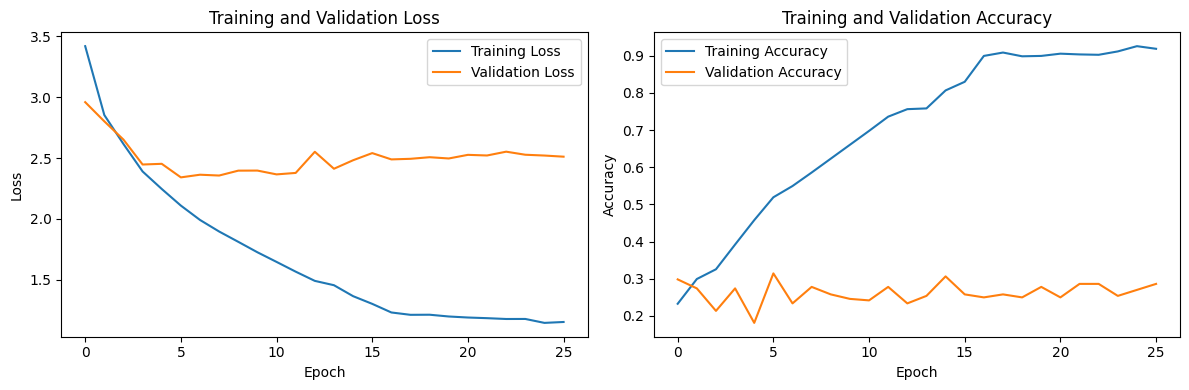

Epoch 1/1000
31/31 [==============================] - 9s 273ms/step - loss: 3.4006 - accuracy: 0.2510 - val_loss: 2.9983 - val_accuracy: 0.2661 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 259ms/step - loss: 2.8618 - accuracy: 0.2812 - val_loss: 2.7711 - val_accuracy: 0.2379 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 259ms/step - loss: 2.6390 - accuracy: 0.3478 - val_loss: 2.6614 - val_accuracy: 0.2782 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 259ms/step - loss: 2.4279 - accuracy: 0.4224 - val_loss: 2.5242 - val_accuracy: 0.2379 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 259ms/step - loss: 2.2766 - accuracy: 0.4758 - val_loss: 2.4671 - val_accuracy: 0.2419 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 258ms/step - loss: 2.1284 - accuracy: 0.5514 - val_loss: 2.4006 - val_accuracy: 0.2379 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

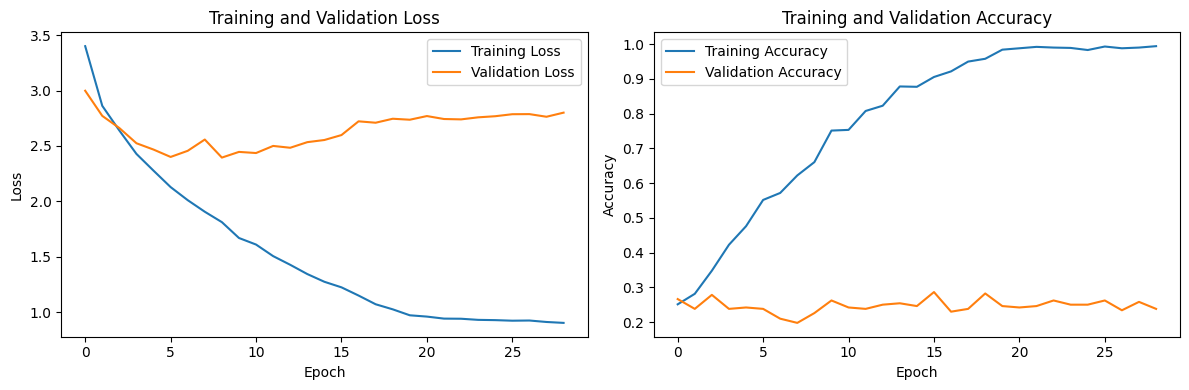

Epoch 1/1000
31/31 [==============================] - 9s 259ms/step - loss: 3.3285 - accuracy: 0.2742 - val_loss: 3.0469 - val_accuracy: 0.1815 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 256ms/step - loss: 2.9037 - accuracy: 0.3095 - val_loss: 2.8692 - val_accuracy: 0.2702 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 257ms/step - loss: 2.7073 - accuracy: 0.3558 - val_loss: 2.6731 - val_accuracy: 0.3145 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 250ms/step - loss: 2.5013 - accuracy: 0.4456 - val_loss: 2.7293 - val_accuracy: 0.1774 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 254ms/step - loss: 2.3486 - accuracy: 0.4808 - val_loss: 2.5393 - val_accuracy: 0.2984 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 251ms/step - loss: 2.2172 - accuracy: 0.5514 - val_loss: 2.4929 - val_accuracy: 0.2702 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

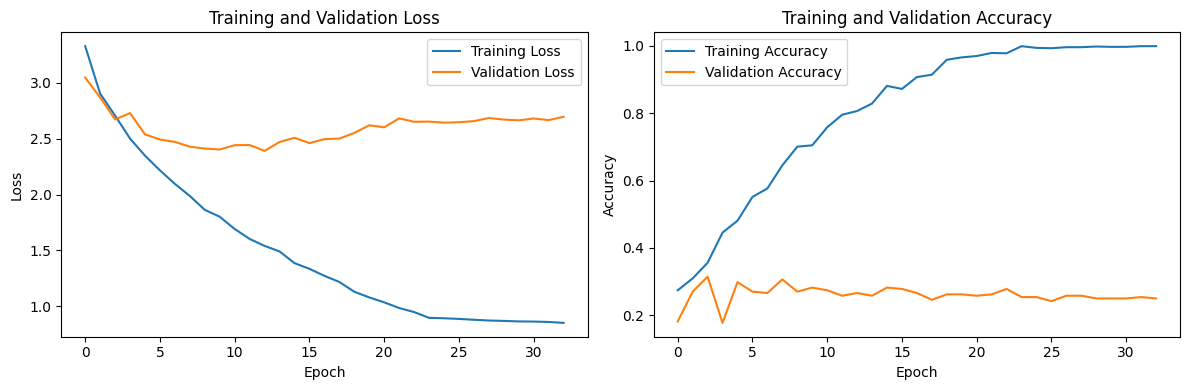

Epoch 1/1000
31/31 [==============================] - 8s 256ms/step - loss: 3.2841 - accuracy: 0.2661 - val_loss: 3.0394 - val_accuracy: 0.2702 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.8939 - accuracy: 0.3095 - val_loss: 2.8386 - val_accuracy: 0.2823 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.6455 - accuracy: 0.3861 - val_loss: 2.7142 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 247ms/step - loss: 2.4806 - accuracy: 0.4224 - val_loss: 2.6188 - val_accuracy: 0.2137 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.2794 - accuracy: 0.5514 - val_loss: 2.5087 - val_accuracy: 0.3226 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 248ms/step - loss: 2.1427 - accuracy: 0.5665 - val_loss: 2.4688 - val_accuracy: 0.2944 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

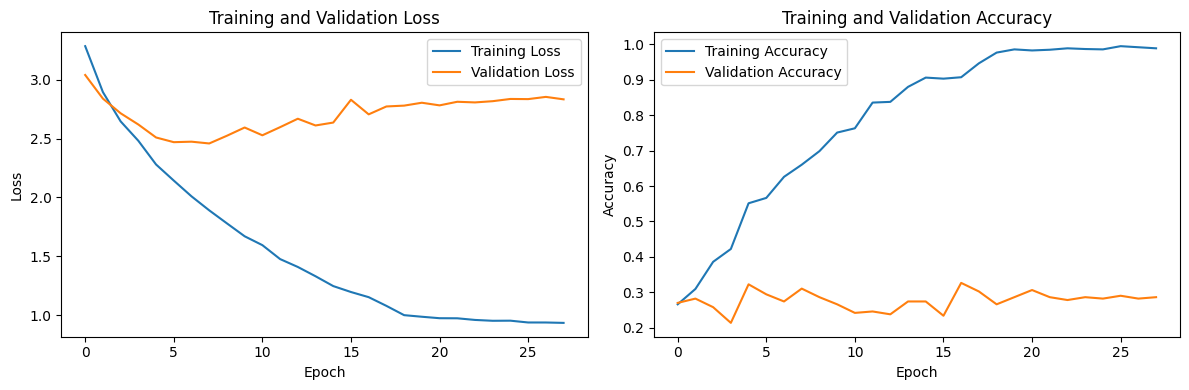

Epoch 1/1000
31/31 [==============================] - 8s 252ms/step - loss: 3.3490 - accuracy: 0.2429 - val_loss: 3.0338 - val_accuracy: 0.2782 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 248ms/step - loss: 2.9141 - accuracy: 0.2833 - val_loss: 2.8306 - val_accuracy: 0.2782 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 245ms/step - loss: 2.6772 - accuracy: 0.3619 - val_loss: 2.6765 - val_accuracy: 0.2903 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 244ms/step - loss: 2.5127 - accuracy: 0.4163 - val_loss: 2.5725 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.3512 - accuracy: 0.4708 - val_loss: 2.4889 - val_accuracy: 0.3065 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 245ms/step - loss: 2.2151 - accuracy: 0.5494 - val_loss: 2.4398 - val_accuracy: 0.3145 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

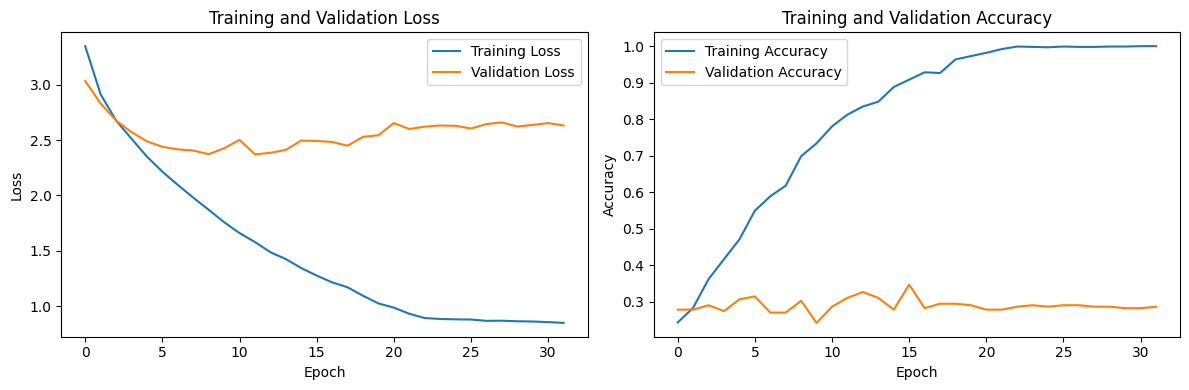

Epoch 1/1000
31/31 [==============================] - 8s 247ms/step - loss: 3.2801 - accuracy: 0.2712 - val_loss: 2.9716 - val_accuracy: 0.3024 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 245ms/step - loss: 2.8811 - accuracy: 0.2883 - val_loss: 2.8097 - val_accuracy: 0.3145 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 244ms/step - loss: 2.6220 - accuracy: 0.3821 - val_loss: 2.6513 - val_accuracy: 0.2298 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 243ms/step - loss: 2.4459 - accuracy: 0.3982 - val_loss: 2.4881 - val_accuracy: 0.3145 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 243ms/step - loss: 2.2789 - accuracy: 0.4798 - val_loss: 2.4970 - val_accuracy: 0.2419 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 7s 243ms/step - loss: 2.1404 - accuracy: 0.5282 - val_loss: 2.3843 - val_accuracy: 0.3306 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

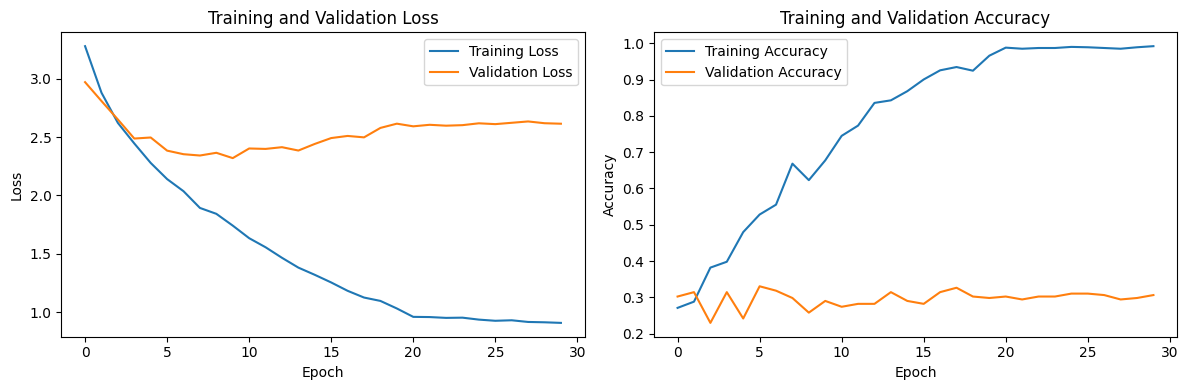

Epoch 1/1000
31/31 [==============================] - 8s 249ms/step - loss: 3.4487 - accuracy: 0.2440 - val_loss: 3.0780 - val_accuracy: 0.2016 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 243ms/step - loss: 2.9200 - accuracy: 0.2702 - val_loss: 2.7956 - val_accuracy: 0.2540 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 7s 242ms/step - loss: 2.6755 - accuracy: 0.3488 - val_loss: 2.6891 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 244ms/step - loss: 2.4821 - accuracy: 0.4284 - val_loss: 2.5653 - val_accuracy: 0.3065 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 244ms/step - loss: 2.3379 - accuracy: 0.4556 - val_loss: 2.5472 - val_accuracy: 0.2056 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 243ms/step - loss: 2.2022 - accuracy: 0.5171 - val_loss: 2.5357 - val_accuracy: 0.2379 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

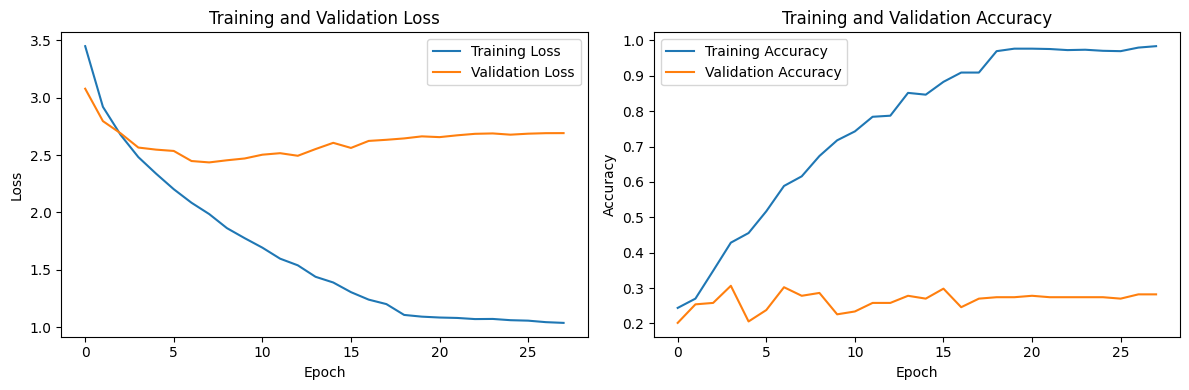

Epoch 1/1000
31/31 [==============================] - 8s 248ms/step - loss: 3.4845 - accuracy: 0.2591 - val_loss: 3.0021 - val_accuracy: 0.3185 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 245ms/step - loss: 2.8921 - accuracy: 0.2772 - val_loss: 2.7389 - val_accuracy: 0.2823 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 7s 242ms/step - loss: 2.6433 - accuracy: 0.3155 - val_loss: 2.6136 - val_accuracy: 0.2984 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 243ms/step - loss: 2.4871 - accuracy: 0.3357 - val_loss: 2.5171 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 243ms/step - loss: 2.3561 - accuracy: 0.3972 - val_loss: 2.4170 - val_accuracy: 0.2379 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 243ms/step - loss: 2.2272 - accuracy: 0.4667 - val_loss: 2.3375 - val_accuracy: 0.3145 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

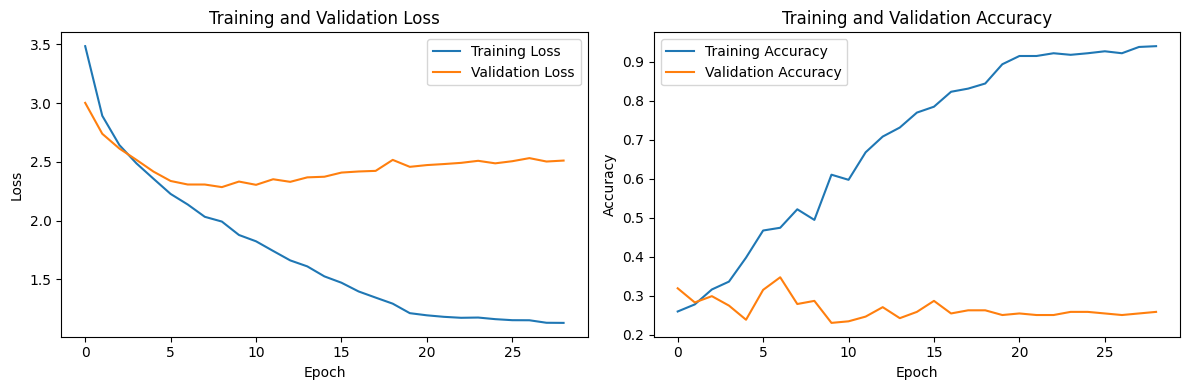

Epoch 1/1000
31/31 [==============================] - 8s 252ms/step - loss: 3.2633 - accuracy: 0.2863 - val_loss: 3.0618 - val_accuracy: 0.2298 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 249ms/step - loss: 2.8804 - accuracy: 0.3014 - val_loss: 2.9448 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.7160 - accuracy: 0.3337 - val_loss: 2.6565 - val_accuracy: 0.2782 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 247ms/step - loss: 2.4871 - accuracy: 0.4284 - val_loss: 2.6206 - val_accuracy: 0.2419 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.3083 - accuracy: 0.4869 - val_loss: 2.5445 - val_accuracy: 0.2419 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 245ms/step - loss: 2.1583 - accuracy: 0.5524 - val_loss: 2.5373 - val_accuracy: 0.2984 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

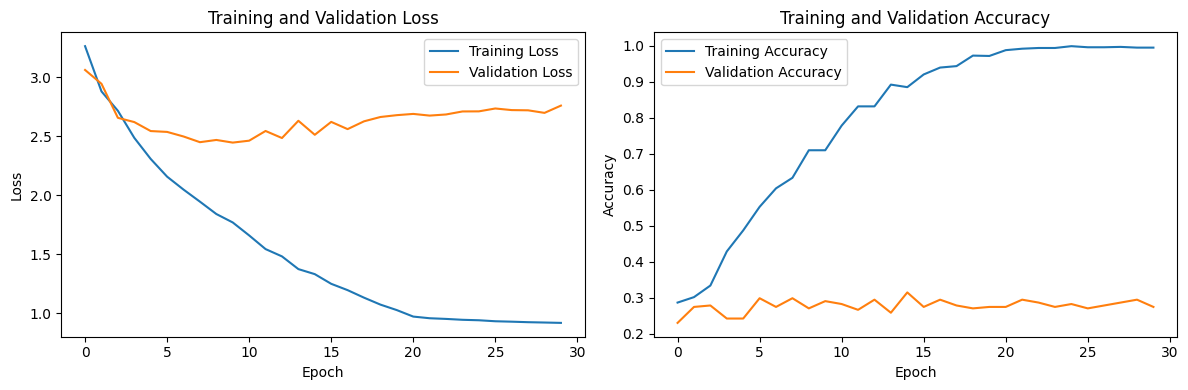

Epoch 1/1000
31/31 [==============================] - 8s 252ms/step - loss: 3.2629 - accuracy: 0.2601 - val_loss: 3.0615 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 247ms/step - loss: 2.8805 - accuracy: 0.3417 - val_loss: 2.8100 - val_accuracy: 0.3226 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 247ms/step - loss: 2.6593 - accuracy: 0.3921 - val_loss: 2.7059 - val_accuracy: 0.2298 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.4477 - accuracy: 0.4637 - val_loss: 2.5908 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.2820 - accuracy: 0.5252 - val_loss: 2.5144 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.1127 - accuracy: 0.6230 - val_loss: 2.5808 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

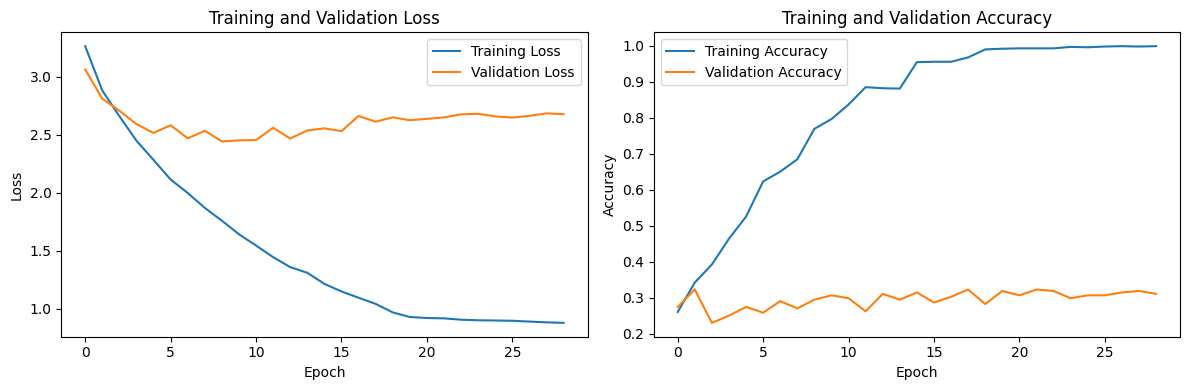

Epoch 1/1000
31/31 [==============================] - 9s 257ms/step - loss: 3.3363 - accuracy: 0.2661 - val_loss: 3.0423 - val_accuracy: 0.2903 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 248ms/step - loss: 2.9546 - accuracy: 0.2702 - val_loss: 2.8522 - val_accuracy: 0.2460 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 243ms/step - loss: 2.7194 - accuracy: 0.3438 - val_loss: 2.6905 - val_accuracy: 0.3065 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 247ms/step - loss: 2.5492 - accuracy: 0.3901 - val_loss: 2.6554 - val_accuracy: 0.2460 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 245ms/step - loss: 2.4102 - accuracy: 0.4486 - val_loss: 2.5317 - val_accuracy: 0.2460 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.2526 - accuracy: 0.5121 - val_loss: 2.5605 - val_accuracy: 0.2177 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

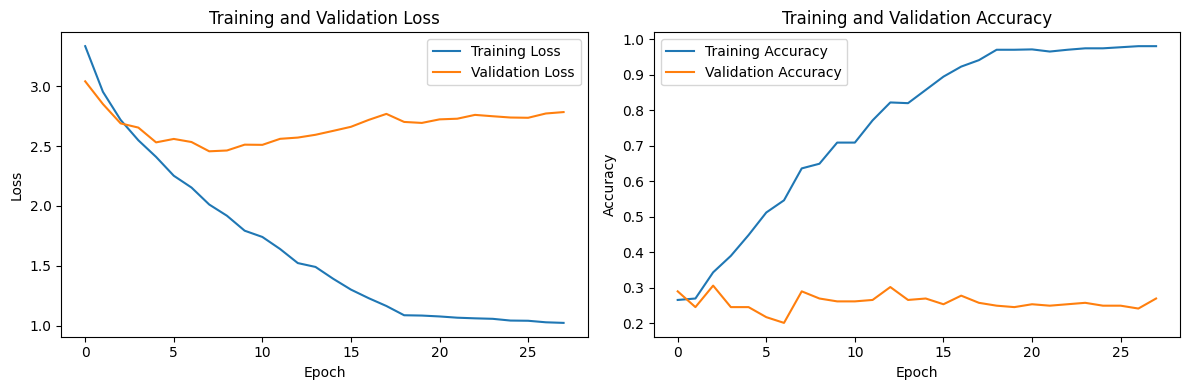

Epoch 1/1000
31/31 [==============================] - 11s 313ms/step - loss: 3.3158 - accuracy: 0.2571 - val_loss: 3.1528 - val_accuracy: 0.1976 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 9s 295ms/step - loss: 2.9127 - accuracy: 0.2812 - val_loss: 2.8324 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 9s 297ms/step - loss: 2.6603 - accuracy: 0.3659 - val_loss: 2.7445 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 9s 293ms/step - loss: 2.4846 - accuracy: 0.4214 - val_loss: 2.5427 - val_accuracy: 0.2944 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 9s 302ms/step - loss: 2.3162 - accuracy: 0.5040 - val_loss: 2.5117 - val_accuracy: 0.2540 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 9s 298ms/step - loss: 2.1697 - accuracy: 0.5454 - val_loss: 2.4853 - val_accuracy: 0.2661 - lr: 1.0000e-04
Epoch 7/1000
31/31 [=============

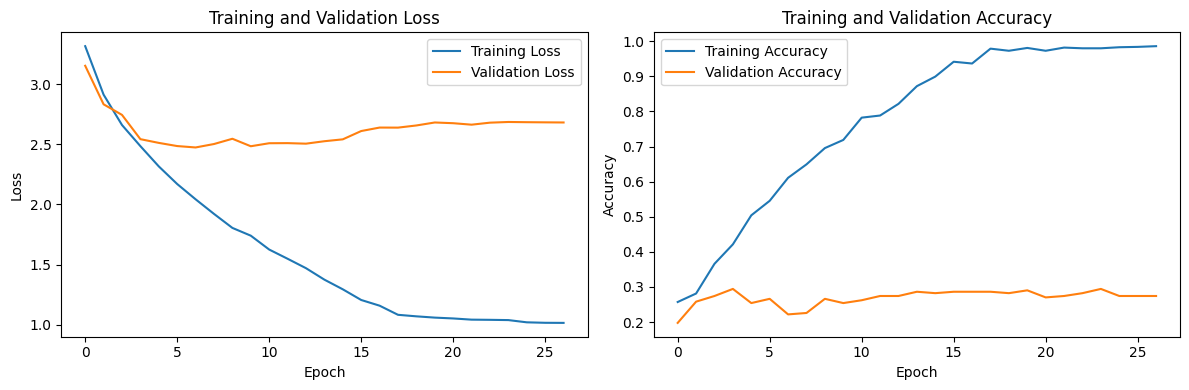

Epoch 1/1000
31/31 [==============================] - 10s 296ms/step - loss: 3.2990 - accuracy: 0.2480 - val_loss: 3.0148 - val_accuracy: 0.2782 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 9s 294ms/step - loss: 2.8468 - accuracy: 0.2984 - val_loss: 2.7915 - val_accuracy: 0.2661 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 9s 292ms/step - loss: 2.6123 - accuracy: 0.3387 - val_loss: 2.5862 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 9s 293ms/step - loss: 2.4047 - accuracy: 0.4335 - val_loss: 2.5475 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 9s 289ms/step - loss: 2.2568 - accuracy: 0.4698 - val_loss: 2.4841 - val_accuracy: 0.2419 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 9s 286ms/step - loss: 2.1063 - accuracy: 0.5383 - val_loss: 2.4319 - val_accuracy: 0.2298 - lr: 1.0000e-04
Epoch 7/1000
31/31 [=============

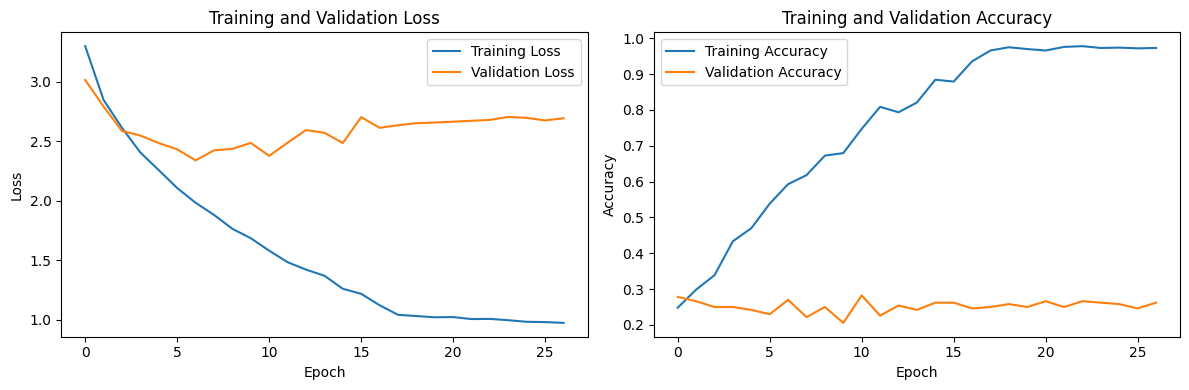

Epoch 1/1000
31/31 [==============================] - 9s 288ms/step - loss: 3.6295 - accuracy: 0.2641 - val_loss: 2.9943 - val_accuracy: 0.3226 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 9s 284ms/step - loss: 2.9369 - accuracy: 0.2752 - val_loss: 2.8248 - val_accuracy: 0.2258 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 9s 282ms/step - loss: 2.7217 - accuracy: 0.3125 - val_loss: 2.6719 - val_accuracy: 0.2863 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 9s 275ms/step - loss: 2.5739 - accuracy: 0.3599 - val_loss: 2.5852 - val_accuracy: 0.3105 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 9s 284ms/step - loss: 2.4094 - accuracy: 0.4073 - val_loss: 2.5261 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 9s 284ms/step - loss: 2.2997 - accuracy: 0.4627 - val_loss: 2.4716 - val_accuracy: 0.2661 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

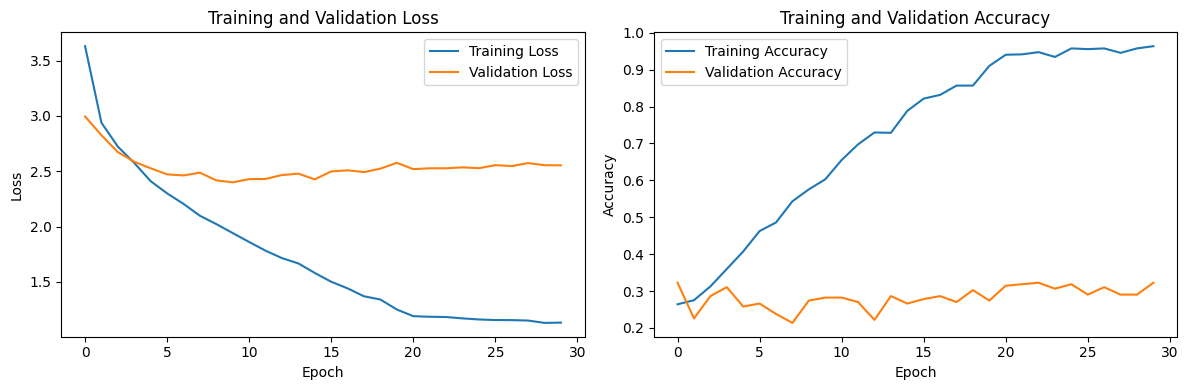

Epoch 1/1000
31/31 [==============================] - 9s 280ms/step - loss: 3.3053 - accuracy: 0.2308 - val_loss: 3.0402 - val_accuracy: 0.2339 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 9s 277ms/step - loss: 2.9094 - accuracy: 0.3155 - val_loss: 2.8607 - val_accuracy: 0.2540 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 9s 277ms/step - loss: 2.6816 - accuracy: 0.3720 - val_loss: 2.6855 - val_accuracy: 0.2823 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 272ms/step - loss: 2.5057 - accuracy: 0.3921 - val_loss: 2.6117 - val_accuracy: 0.2460 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 269ms/step - loss: 2.3787 - accuracy: 0.4032 - val_loss: 2.5297 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 9s 275ms/step - loss: 2.2374 - accuracy: 0.4960 - val_loss: 2.5107 - val_accuracy: 0.2097 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

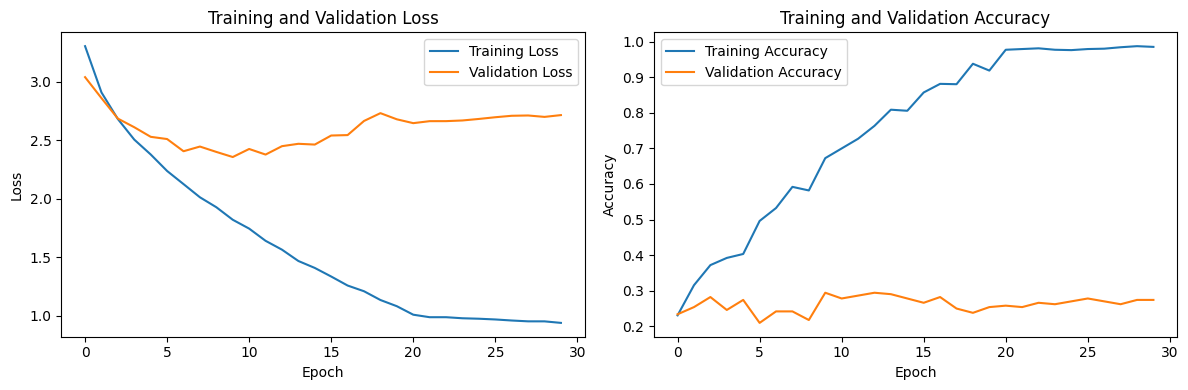

Epoch 1/1000
31/31 [==============================] - 9s 272ms/step - loss: 3.3211 - accuracy: 0.2540 - val_loss: 3.0330 - val_accuracy: 0.3226 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 266ms/step - loss: 2.9030 - accuracy: 0.3034 - val_loss: 2.7974 - val_accuracy: 0.3024 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 266ms/step - loss: 2.6653 - accuracy: 0.3911 - val_loss: 2.6848 - val_accuracy: 0.2339 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 265ms/step - loss: 2.4898 - accuracy: 0.4425 - val_loss: 2.5842 - val_accuracy: 0.2903 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 268ms/step - loss: 2.3139 - accuracy: 0.5081 - val_loss: 2.5063 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 265ms/step - loss: 2.1521 - accuracy: 0.5917 - val_loss: 2.5017 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

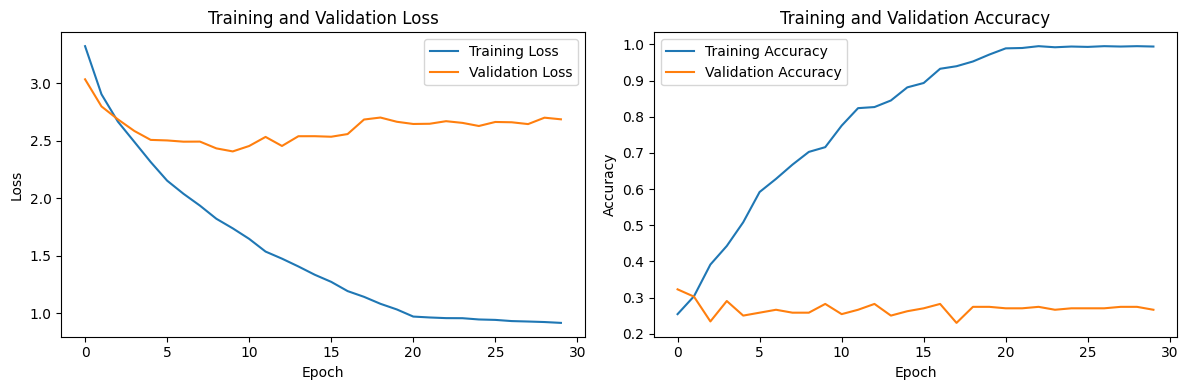

Epoch 1/1000
31/31 [==============================] - 9s 268ms/step - loss: 3.4766 - accuracy: 0.2308 - val_loss: 2.9749 - val_accuracy: 0.3226 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 259ms/step - loss: 2.9169 - accuracy: 0.2833 - val_loss: 2.7488 - val_accuracy: 0.3065 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 259ms/step - loss: 2.6727 - accuracy: 0.3317 - val_loss: 2.5976 - val_accuracy: 0.3185 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 259ms/step - loss: 2.5084 - accuracy: 0.3619 - val_loss: 2.5063 - val_accuracy: 0.2702 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 259ms/step - loss: 2.3493 - accuracy: 0.4204 - val_loss: 2.5036 - val_accuracy: 0.2460 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 258ms/step - loss: 2.2327 - accuracy: 0.4768 - val_loss: 2.4429 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

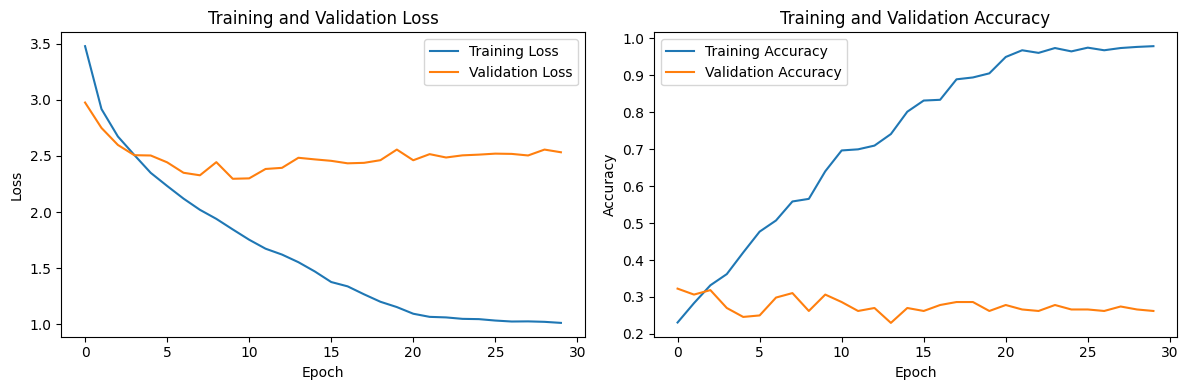

Epoch 1/1000
31/31 [==============================] - 9s 264ms/step - loss: 3.3088 - accuracy: 0.2641 - val_loss: 3.1441 - val_accuracy: 0.2298 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 254ms/step - loss: 2.9349 - accuracy: 0.2833 - val_loss: 2.8007 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 257ms/step - loss: 2.7103 - accuracy: 0.3296 - val_loss: 2.6651 - val_accuracy: 0.2944 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 258ms/step - loss: 2.5141 - accuracy: 0.3962 - val_loss: 2.5965 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 256ms/step - loss: 2.3931 - accuracy: 0.4183 - val_loss: 2.5574 - val_accuracy: 0.2702 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 257ms/step - loss: 2.2646 - accuracy: 0.4577 - val_loss: 2.4942 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

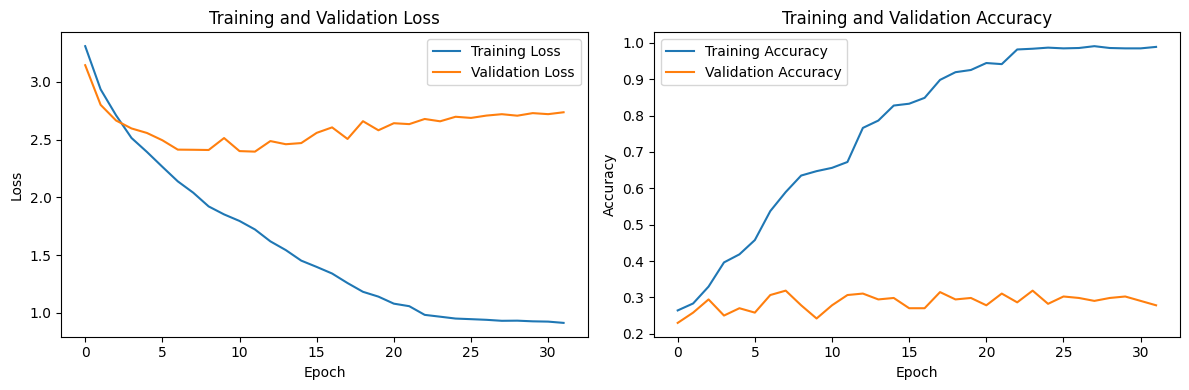

Epoch 1/1000
31/31 [==============================] - 9s 258ms/step - loss: 3.2361 - accuracy: 0.2591 - val_loss: 2.9888 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 252ms/step - loss: 2.8676 - accuracy: 0.3266 - val_loss: 2.7943 - val_accuracy: 0.3105 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 252ms/step - loss: 2.6014 - accuracy: 0.4032 - val_loss: 2.6569 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 251ms/step - loss: 2.4039 - accuracy: 0.4819 - val_loss: 2.6074 - val_accuracy: 0.2460 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 253ms/step - loss: 2.2197 - accuracy: 0.5544 - val_loss: 2.5037 - val_accuracy: 0.3226 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 253ms/step - loss: 2.0829 - accuracy: 0.5968 - val_loss: 2.4298 - val_accuracy: 0.3145 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

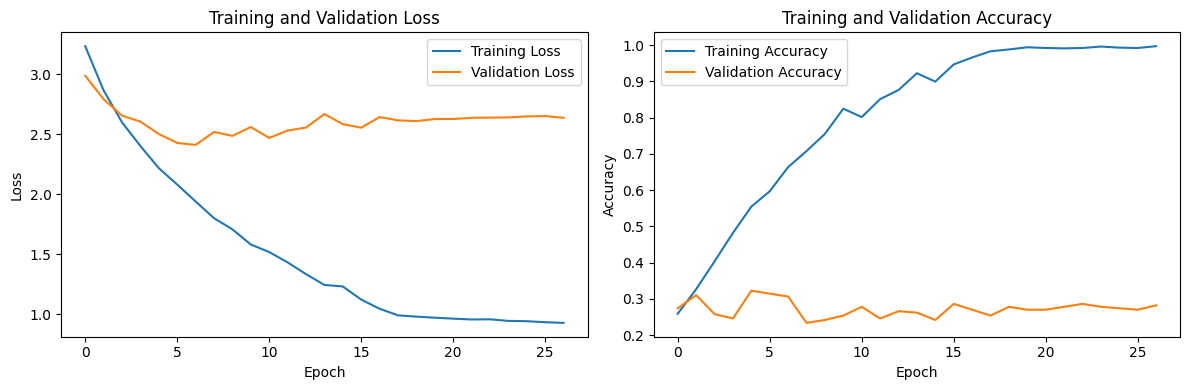

Epoch 1/1000
31/31 [==============================] - 8s 255ms/step - loss: 3.2508 - accuracy: 0.2611 - val_loss: 3.0299 - val_accuracy: 0.1734 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 251ms/step - loss: 2.8767 - accuracy: 0.2833 - val_loss: 2.7794 - val_accuracy: 0.2177 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 249ms/step - loss: 2.5847 - accuracy: 0.3347 - val_loss: 2.5395 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 249ms/step - loss: 2.3855 - accuracy: 0.3851 - val_loss: 2.4282 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 248ms/step - loss: 2.2287 - accuracy: 0.4536 - val_loss: 2.3876 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 250ms/step - loss: 2.1057 - accuracy: 0.4940 - val_loss: 2.3623 - val_accuracy: 0.2339 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

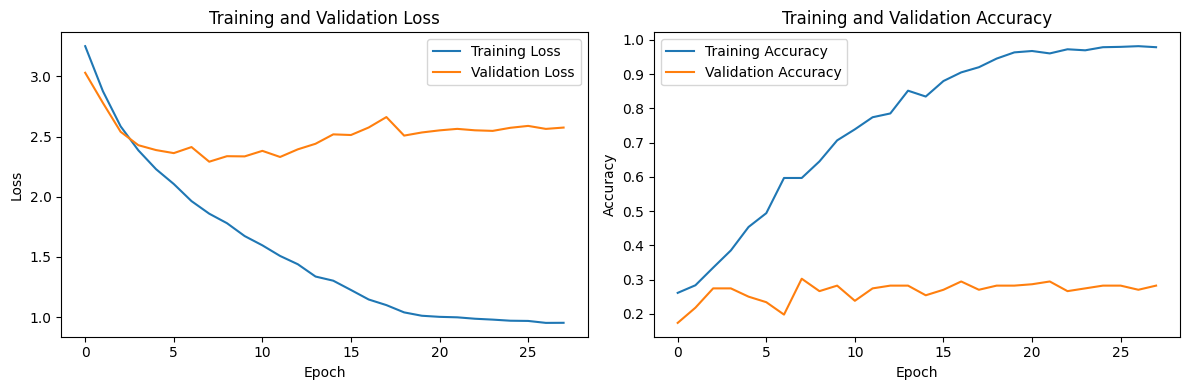

Epoch 1/1000
31/31 [==============================] - 8s 253ms/step - loss: 3.3598 - accuracy: 0.2631 - val_loss: 3.0453 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 248ms/step - loss: 2.9472 - accuracy: 0.2883 - val_loss: 2.8712 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.7022 - accuracy: 0.3569 - val_loss: 2.8327 - val_accuracy: 0.2056 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.5205 - accuracy: 0.4153 - val_loss: 2.6045 - val_accuracy: 0.2823 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 247ms/step - loss: 2.3689 - accuracy: 0.4728 - val_loss: 2.5515 - val_accuracy: 0.2460 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 245ms/step - loss: 2.2287 - accuracy: 0.5202 - val_loss: 2.6203 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

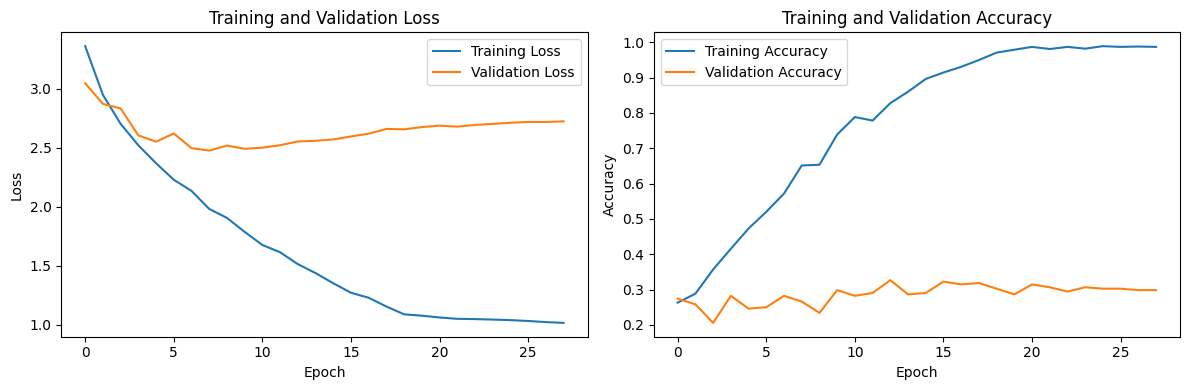

Epoch 1/1000
31/31 [==============================] - 8s 252ms/step - loss: 3.3088 - accuracy: 0.2440 - val_loss: 3.0017 - val_accuracy: 0.1855 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 247ms/step - loss: 2.8690 - accuracy: 0.2802 - val_loss: 2.7120 - val_accuracy: 0.2702 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.5750 - accuracy: 0.3599 - val_loss: 2.5870 - val_accuracy: 0.2177 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 245ms/step - loss: 2.3779 - accuracy: 0.4103 - val_loss: 2.4973 - val_accuracy: 0.2621 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.2325 - accuracy: 0.4506 - val_loss: 2.4052 - val_accuracy: 0.2460 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 245ms/step - loss: 2.0636 - accuracy: 0.5847 - val_loss: 2.3959 - val_accuracy: 0.2540 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

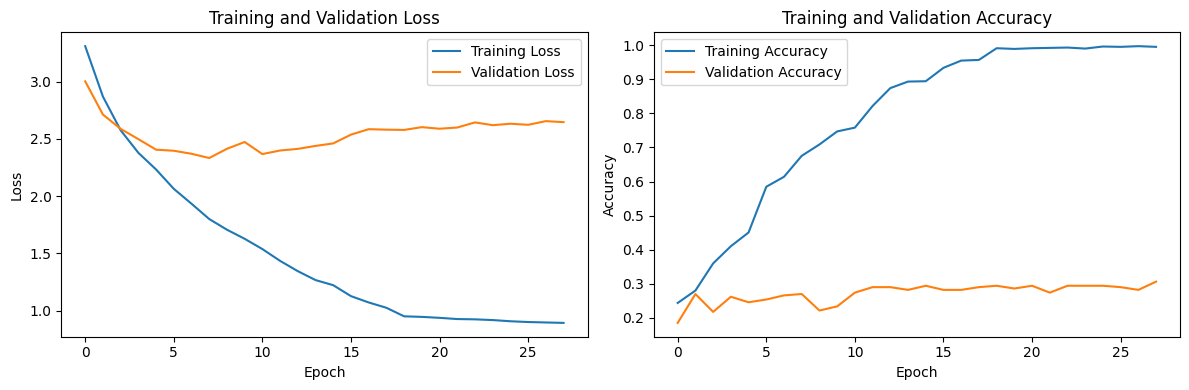

Epoch 1/1000
31/31 [==============================] - 8s 254ms/step - loss: 3.4181 - accuracy: 0.2621 - val_loss: 3.2437 - val_accuracy: 0.1976 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 7s 240ms/step - loss: 2.8855 - accuracy: 0.2893 - val_loss: 2.7626 - val_accuracy: 0.2661 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 7s 242ms/step - loss: 2.6221 - accuracy: 0.3528 - val_loss: 2.6209 - val_accuracy: 0.2621 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 244ms/step - loss: 2.4487 - accuracy: 0.3952 - val_loss: 2.5367 - val_accuracy: 0.2177 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 245ms/step - loss: 2.2852 - accuracy: 0.4677 - val_loss: 2.4351 - val_accuracy: 0.2621 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 246ms/step - loss: 2.1384 - accuracy: 0.5393 - val_loss: 2.4132 - val_accuracy: 0.2540 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

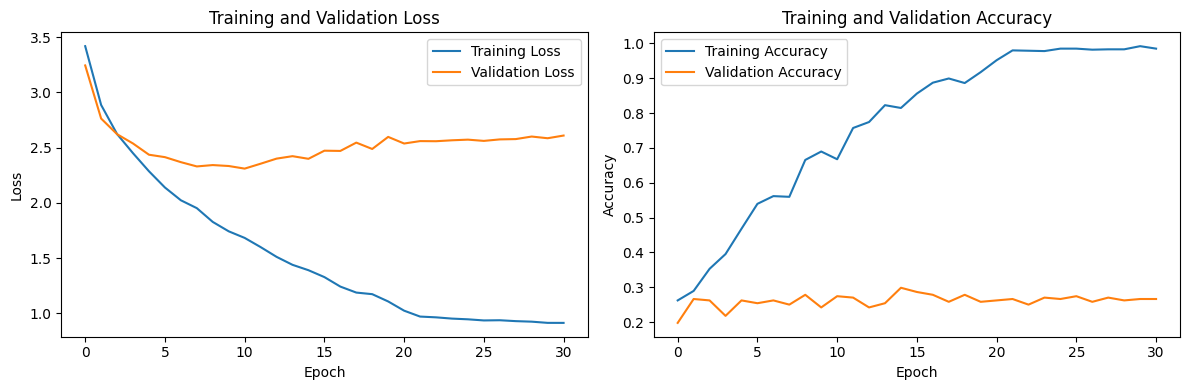

Epoch 1/1000
31/31 [==============================] - 8s 248ms/step - loss: 3.3052 - accuracy: 0.2762 - val_loss: 2.9826 - val_accuracy: 0.2944 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 7s 240ms/step - loss: 2.8624 - accuracy: 0.3004 - val_loss: 2.7906 - val_accuracy: 0.2540 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 7s 242ms/step - loss: 2.6017 - accuracy: 0.3478 - val_loss: 2.6124 - val_accuracy: 0.2379 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 10s 314ms/step - loss: 2.4158 - accuracy: 0.4062 - val_loss: 2.5819 - val_accuracy: 0.2137 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 9s 295ms/step - loss: 2.2625 - accuracy: 0.4577 - val_loss: 2.4412 - val_accuracy: 0.2460 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 9s 294ms/step - loss: 2.1083 - accuracy: 0.5242 - val_loss: 2.4434 - val_accuracy: 0.2621 - lr: 1.0000e-04
Epoch 7/1000
31/31 [=============

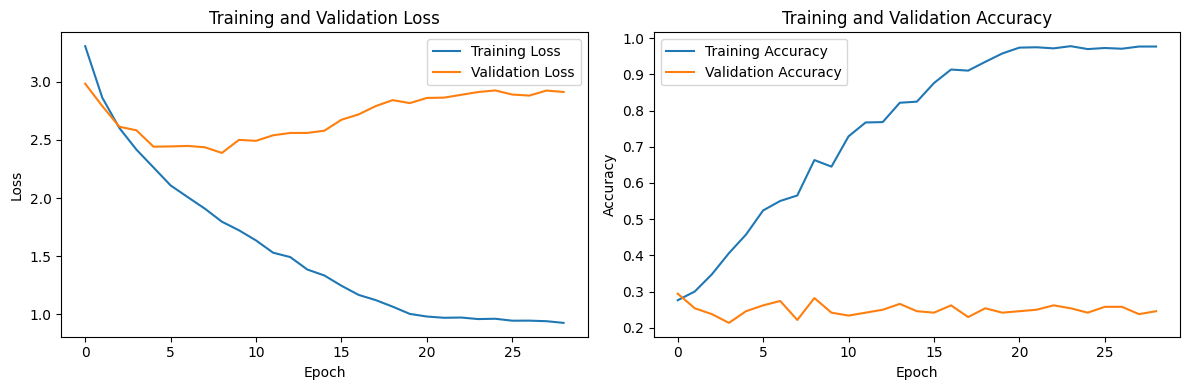

Epoch 1/1000
31/31 [==============================] - 10s 290ms/step - loss: 3.4910 - accuracy: 0.2671 - val_loss: 2.9492 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 9s 281ms/step - loss: 2.8551 - accuracy: 0.2772 - val_loss: 2.7310 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 9s 287ms/step - loss: 2.6242 - accuracy: 0.3044 - val_loss: 2.6411 - val_accuracy: 0.2379 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 9s 289ms/step - loss: 2.4246 - accuracy: 0.3790 - val_loss: 2.4673 - val_accuracy: 0.2661 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 9s 291ms/step - loss: 2.2626 - accuracy: 0.4446 - val_loss: 2.5198 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 9s 285ms/step - loss: 2.1436 - accuracy: 0.4970 - val_loss: 2.3999 - val_accuracy: 0.2218 - lr: 1.0000e-04
Epoch 7/1000
31/31 [=============

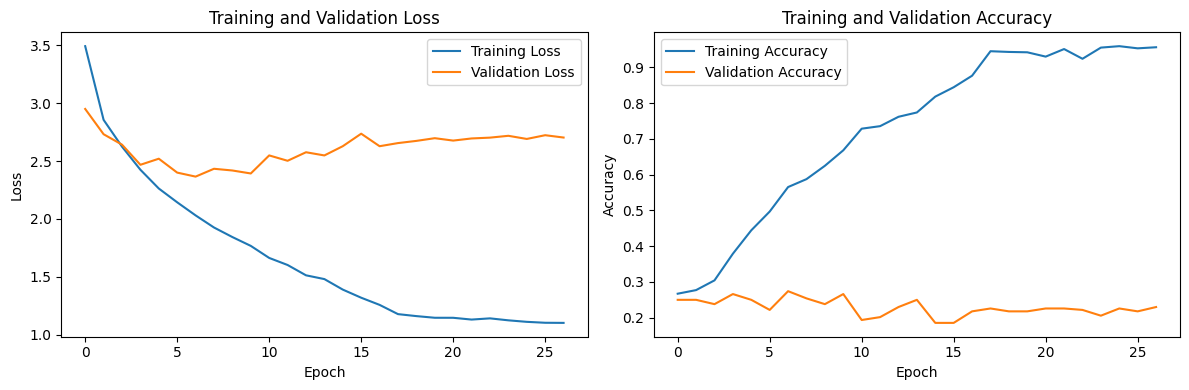

Epoch 1/1000
31/31 [==============================] - 9s 286ms/step - loss: 3.3394 - accuracy: 0.2681 - val_loss: 3.0083 - val_accuracy: 0.3266 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 272ms/step - loss: 2.9686 - accuracy: 0.2712 - val_loss: 2.9021 - val_accuracy: 0.2339 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 9s 286ms/step - loss: 2.7288 - accuracy: 0.3448 - val_loss: 2.7414 - val_accuracy: 0.2419 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 274ms/step - loss: 2.5484 - accuracy: 0.4315 - val_loss: 2.6115 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 9s 275ms/step - loss: 2.3900 - accuracy: 0.4577 - val_loss: 2.5556 - val_accuracy: 0.2621 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 273ms/step - loss: 2.2673 - accuracy: 0.4990 - val_loss: 2.5895 - val_accuracy: 0.2258 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

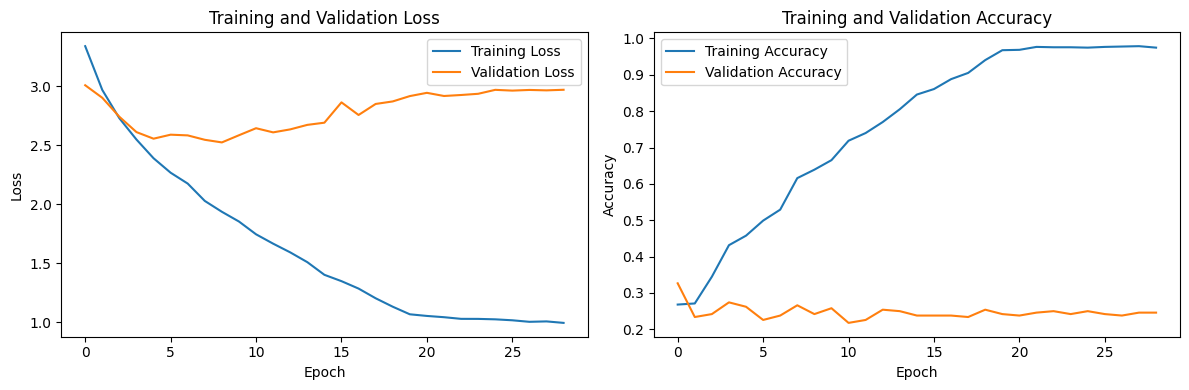

Epoch 1/1000
31/31 [==============================] - 9s 281ms/step - loss: 3.3128 - accuracy: 0.2702 - val_loss: 2.9939 - val_accuracy: 0.2903 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 266ms/step - loss: 2.9157 - accuracy: 0.2994 - val_loss: 2.8070 - val_accuracy: 0.2782 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 271ms/step - loss: 2.6963 - accuracy: 0.3085 - val_loss: 2.6897 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 268ms/step - loss: 2.4834 - accuracy: 0.4315 - val_loss: 2.6352 - val_accuracy: 0.2500 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 268ms/step - loss: 2.3614 - accuracy: 0.4466 - val_loss: 2.5347 - val_accuracy: 0.2661 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 271ms/step - loss: 2.1936 - accuracy: 0.5625 - val_loss: 2.5183 - val_accuracy: 0.2540 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

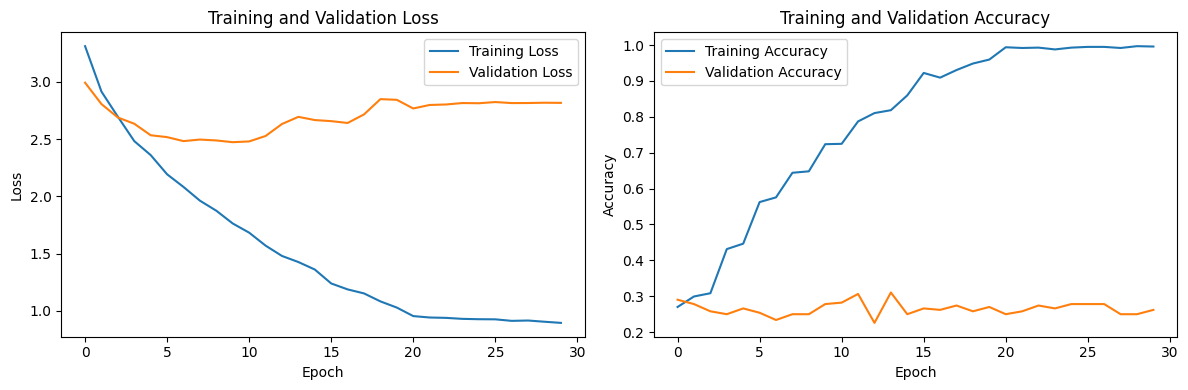

Epoch 1/1000
31/31 [==============================] - 9s 274ms/step - loss: 3.3225 - accuracy: 0.2550 - val_loss: 2.9871 - val_accuracy: 0.2661 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 262ms/step - loss: 2.8683 - accuracy: 0.2923 - val_loss: 2.7949 - val_accuracy: 0.2782 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 261ms/step - loss: 2.5984 - accuracy: 0.3810 - val_loss: 2.6173 - val_accuracy: 0.2540 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 263ms/step - loss: 2.4218 - accuracy: 0.4062 - val_loss: 2.5384 - val_accuracy: 0.2177 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 261ms/step - loss: 2.2439 - accuracy: 0.5161 - val_loss: 2.5119 - val_accuracy: 0.2460 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 263ms/step - loss: 2.0964 - accuracy: 0.5423 - val_loss: 2.4226 - val_accuracy: 0.2621 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

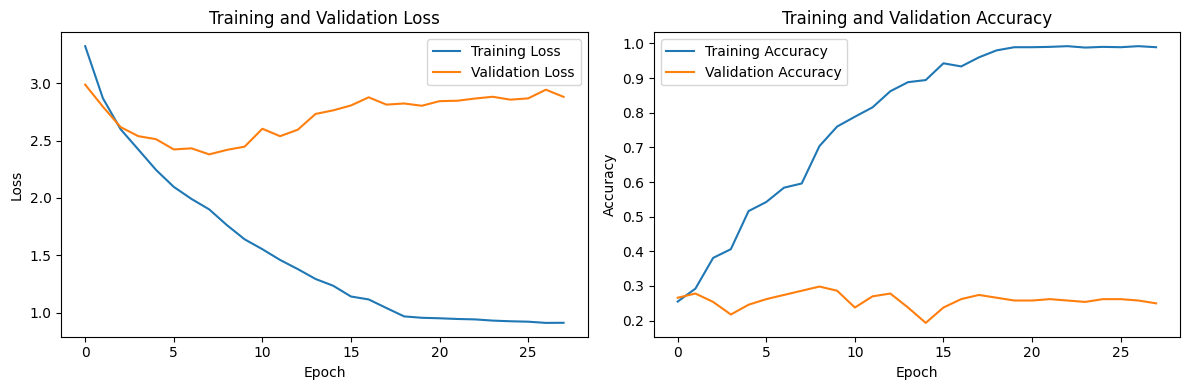

Epoch 1/1000
31/31 [==============================] - 9s 270ms/step - loss: 3.5103 - accuracy: 0.2530 - val_loss: 3.1666 - val_accuracy: 0.1290 - lr: 1.0000e-04
Epoch 2/1000
31/31 [==============================] - 8s 257ms/step - loss: 2.8888 - accuracy: 0.2762 - val_loss: 2.7413 - val_accuracy: 0.2581 - lr: 1.0000e-04
Epoch 3/1000
31/31 [==============================] - 8s 258ms/step - loss: 2.6118 - accuracy: 0.3286 - val_loss: 2.6610 - val_accuracy: 0.2742 - lr: 1.0000e-04
Epoch 4/1000
31/31 [==============================] - 8s 255ms/step - loss: 2.4383 - accuracy: 0.3891 - val_loss: 2.5344 - val_accuracy: 0.2137 - lr: 1.0000e-04
Epoch 5/1000
31/31 [==============================] - 8s 255ms/step - loss: 2.2749 - accuracy: 0.4627 - val_loss: 2.4534 - val_accuracy: 0.2782 - lr: 1.0000e-04
Epoch 6/1000
31/31 [==============================] - 8s 257ms/step - loss: 2.1690 - accuracy: 0.4879 - val_loss: 2.3299 - val_accuracy: 0.3105 - lr: 1.0000e-04
Epoch 7/1000
31/31 [==============

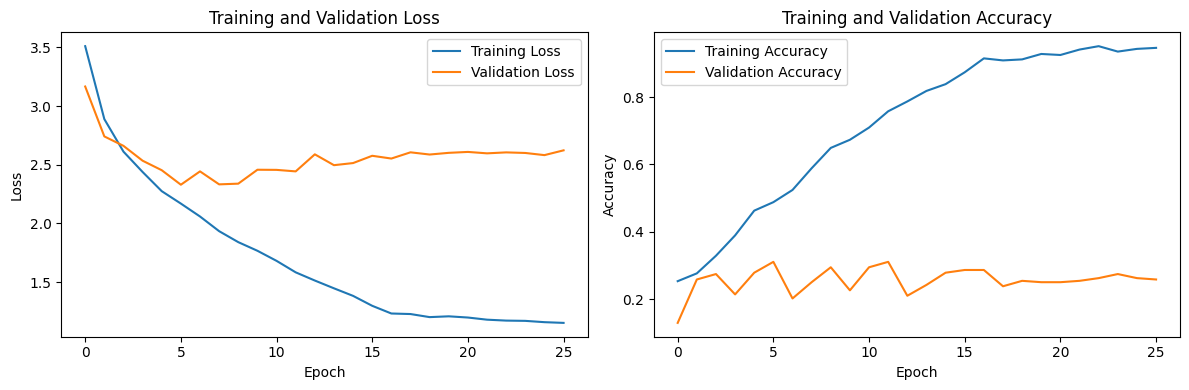

Average Classification Accuracy: 0.8203125


In [83]:
num_subjects = participant_dde_features.shape[0]
num_trials = participant_dde_features.shape[1]
num_classes = 4  # Assuming you have 4 emotion classes

# Best hyperparameters
best_dropout_rate = 0.3
best_optimizer = 'adam'

# Reshape the data to fit the CNN input shape
input_shape = (participant_dde_features.shape[2], participant_dde_features.shape[3], 1)

# Initialize KFold cross-validation
kf = KFold(n_splits=num_subjects)

# Placeholder for storing accuracy scores
accuracy_scores = []

# Placeholder for storing loss history
loss_history = []

# Initialize the Early Stopping callback with adjusted patience and monitoring metric
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)


# Iterate through each subject as the test set
for train_subjects, test_subject in kf.split(np.arange(num_subjects)):
    # Select data for training and testing
    X_train = participant_dde_features[train_subjects].reshape(-1, *input_shape)
    y_train = quadrant_labels_int[train_subjects].flatten()
    
    X_test = participant_dde_features[test_subjects].reshape(-1, *input_shape)
    y_test = quadrant_labels_int[test_subjects].flatten()
    
    # Create the CNN model with different strategies
    model = create_cnn_model(input_shape, dropout_rate=0.3, regularization_strength=0.001)
    
    # Apply Early Stopping and Learning Rate Annealing
    early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
    lr_reduction = ReduceLROnPlateau(factor=0.1, patience=10)
    
    # Train the model with callbacks
    history = model.fit(X_train, y_train, epochs=1000, batch_size=32,
                                 validation_split=0.2, callbacks=[early_stopping, lr_reduction], verbose=1)
    

    # Append loss and accuracy history to the lists
    loss_history.append(history.history['loss'])
    accuracy_history.append(history.history['accuracy'])

    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate accuracy and store it
    accuracy = accuracy_score(y_test, y_pred_classes)
    accuracy_scores.append(accuracy)


    # Plot loss and accuracy curves for this fold
    plt.figure(figsize=(12, 4))

    # Plot training and validation loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Calculate the average accuracy
average_accuracy = np.mean(accuracy_scores)
print("Average Classification Accuracy:", average_accuracy)


In [ ]:

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

